# LSTM code for damage localization based on time-history dataset 

# Define Functions

### Function for R^2 coefficient

In [1]:
#--------------------------------R^2 coefficient for variance------------
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

### Split

In [2]:
def split1(X, y, mvalid, mtest): # full dataset
    
    # split
    X1, Xtest, y1, ytest = train_test_split(X,y, test_size = mtest, random_state = 42)
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X1,y1, test_size = mvalid, random_state = 42)
    
    return [Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest];

In [3]:
def split2(Xn, yn, mvalid, mtest): # for noise + full dataset
    
    import random
    
    # split
    X1, Xtest, y1, ytest = train_test_split(Xn,yn, test_size = mtest, random_state = 42)
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X1,y1, test_size = mvalid, random_state = 42)
    
    return [Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest];

In [4]:
def split3(Xn, yn, m, mvalid, mtest): # noise + reduced dataset
    
    import random
    
    # dataset
    n = random.sample(range(1, Xn.shape[0]), m)
    Xn = Xn[n,:] # Xn should be defined
    yn = yn[n]   # yn should be defined
    
    # split
    X1, Xtest, y1, ytest = train_test_split(Xn,yn, test_size = mtest, random_state = 42)
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(X1,y1, test_size = mvalid, random_state = 42)
    
    return [Xtrain, ytrain, Xvalid, yvalid, Xtest, ytest];

### Model architecture

In [5]:
def RNN(n_timesteps,n_features, nlstm):
    
    # define model architecture : 1DCNN for regression
    model = Sequential()
    
    # LSTM layers
    model.add(LSTM(nlstm, return_sequences = True, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.05))
    #model.add(CuDNNLSTM(8, return_sequences = True))
    #model.add(Dropout(0.05))
    
    model.add(Flatten())
    
    # Dense Layers
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    #model.add(Dense(16, activation='relu'))
    
    # Output Layer
    model.add(Dense(2, activation='linear'))
    
    return model

### Training

In [6]:
def train(Xtrain, ytrain, Xvalid, yvalid, model, alpha, nepoch, batchsize):
    
    # otherparameters
    m_train = Xtrain.shape[0]
    m_valid = Xvalid.shape[0]
    
    # reshape the array
    Xtrain = np.reshape(Xtrain, (m_train,n_timesteps,n_features)) # n_timesteps and n_feature = defined
    Xvalid = np.reshape(Xvalid, (m_valid,n_timesteps,n_features))
    
    model.compile(loss='mse', optimizer=Adam(lr=alpha,beta_1=0.9,beta_2=0.999), metrics=['mape','mae',r_square])
    
    # train the model
    
    history = model.fit(Xtrain, ytrain, validation_data=(Xvalid, yvalid), epochs=nepoch, batch_size = batchsize, verbose=2, shuffle = True)
    
    return [model, history];

### Plots 

In [7]:
def mseplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['loss'],'-o')
    plt.plot(history.history['val_loss'],'-s')
    plt.title('MSE loss for Damage localization (LSTM)',fontsize=font+2)
    plt.ylabel('MSE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def maeplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['mae'],'-o')
    plt.plot(history.history['val_mae'],'-s')
    plt.title('MAE for Damage localization (LSTM)',fontsize=font+2)
    plt.ylabel('MAE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def mapeplot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['mape'],'-o')
    plt.plot(history.history['val_mape'],'-s')
    plt.title('MAPE for Damage localization (LSTM)',fontsize=font+2)
    plt.ylabel('MAPE',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

def r2plot(history, lb, ub, font, ep1, ep2):
    plt.figure(figsize=(14,8))
    plt.plot(history.history['r_square'],'-o')
    plt.plot(history.history['val_r_square'],'-s')
    plt.title('R^2 for Damage localization (LSTM)',fontsize=font+2)
    plt.ylabel('R^2',fontsize=font)
    plt.xticks(fontsize=font)
    plt.yticks(fontsize=font)
    plt.xlabel('Number of epochs',fontsize=font)
    plt.legend(['train', 'test'], loc='upper right',fontsize=font)
    plt.axis([ep1,ep2,lb,ub])
    return plt.show()

### Prediction 

In [8]:
def pred(model,Xtest,ytest,name):
    
    m_test = Xtest.shape[0]
    Xtest = np.reshape(Xtest,(m_test,n_timesteps,n_features))
    y_predicted = model.predict(Xtest, verbose=2)
    y_predicted = np.array(y_predicted)
    y_actual = ytest
    
    diff = y_predicted - y_actual
    percentDiff = (diff / y_actual) * 100
    absPercentDiff = np.abs(percentDiff)
    APD = pd.DataFrame(absPercentDiff)
    APD = round(APD,2)
    
    import xlsxwriter
    
    y_actual = np.array(y_actual)
    APD = np.array(APD)
  
    workbook = xlsxwriter.Workbook(name) 
  
    # By default worksheet names in the spreadsheet will be  
    # Sheet1, Sheet2 etc., but we can also specify a name. 
    worksheet = workbook.add_worksheet("My sheet") 

    worksheet.write(0, 0, 'True values (x)') 
    worksheet.write(0, 1, 'True values (a)')
    worksheet.write(0, 2, 'Predicted values (x)') 
    worksheet.write(0, 3, 'Predicted values (a)')
    worksheet.write(0, 4, 'APD (x)') 
    worksheet.write(0, 5, 'APD (a)') 

    # columns are indexed from 1. 
    row = 1
    col = 0

    # Iterate over the data and write it out row by row. 
    for i in range(0, len(y_actual)):
        worksheet.write(row, col, y_actual[i,0])
        worksheet.write(row, col + 1, y_actual[i,1]) 
        worksheet.write(row, col + 2, y_predicted[i,0])
        worksheet.write(row, col + 3, y_predicted[i,1])
        worksheet.write(row, col + 4, APD[i,0]) 
        worksheet.write(row, col + 5, APD[i,1]) 
        row += 1
  
    workbook.close()

    excel = pd.read_excel(name)
    
    return excel

## Importing APIs

In [9]:
#import os, signal
#os.kill(os.getpid(), signal.SIGTERM)

In [10]:
#------------------------------------------imports----------------------------
%matplotlib inline
import tensorflow as tf

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Activation, MaxPooling1D, Dropout, Lambda 
from tensorflow.keras.layers import Dense, Conv1D, SimpleRNN, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

Using TensorFlow backend.


In [11]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Callbacks

In [12]:
#-----------------------------------------callbacks---------------------------
# 1. Epoch Schedule
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_mean_absolute_error')<1.25) and (logs.get('mean_absolute_error')<1.25) and (logs.get('val_loss')<3) and (logs.get('loss')<3) and (abs(logs.get('val_loss') - logs.get('loss')) < 0.5):
      print("\nReached perfect accuracy so cancelling training!")
      self.model.stop_training = True

epoch_schedule = myCallback()

# 2. Saving weight checkpoint

filepath = "gdrive/My Drive/save_weights/epochs:{epoch:03d}-loss:{loss:.3f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min',period=100)

# 3. Learning Rate Schedule      
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 2.5))

## Importing Dataset

In [13]:
df_D_Ax = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/0_DataSet/Ax2500_D_03Aug20.txt',header=None)
df_D_Flex = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/0_DataSet/Flex2500_D_03Aug20.txt',header=None)
y = pd.read_excel('D:/SDE/1_SDEisotropicDL/CollectData/2_Labels/labelsD.xlsx',header=None)

In [14]:
print(df_D_Ax.shape)
print(df_D_Flex.shape)
print(y.shape)

(2500, 8192)
(2500, 8192)
(2500, 2)


## Plots 

In [15]:
nfft = 1024*8
T = 0.5e-6*nfft
q = 120e3
deltaT = T/nfft
t = np.arange(0,(nfft-1)/nfft,1/nfft)
time = t*T
print(time)

[0.0000e+00 5.0000e-07 1.0000e-06 ... 4.0940e-03 4.0945e-03 4.0950e-03]


1570


Text(0, 0.5, 'Amplitude')

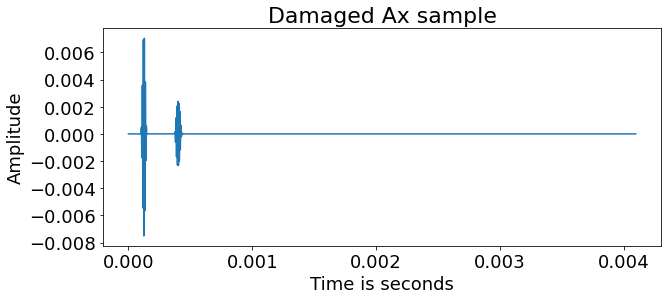

In [16]:
import random 
N = random.randint(1, 2500)
plt.figure(figsize=(10,4))
plt.plot(time, df_D_Ax.iloc[N, 0 : df_D_Ax.shape[1]-1])
plt.title('Damaged Ax sample',fontsize=22)
print(N)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time is seconds',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)

1570


Text(0, 0.5, 'Amplitude')

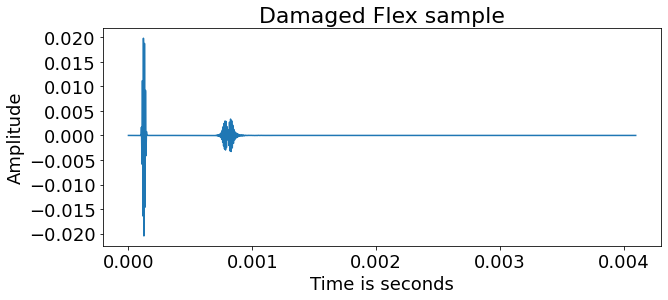

In [17]:
plt.figure(figsize=(10,4))
plt.plot(time, df_D_Flex.iloc[N, 0 : df_D_Flex.shape[1]-1])
plt.title('Damaged Flex sample',fontsize=22)
print(N)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time is seconds',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)

## Combined 

In [18]:
df_D = df_D_Ax + df_D_Flex

1570


Text(0, 0.5, 'Amplitude')

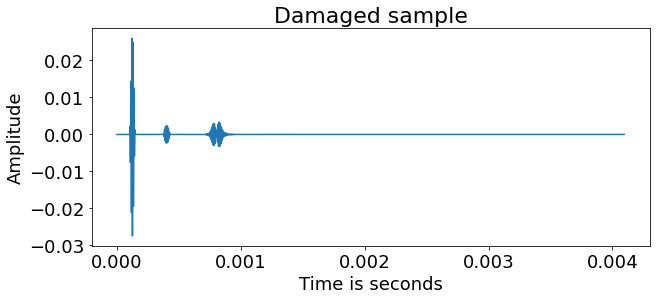

In [19]:
plt.figure(figsize=(10,4))
plt.plot(time, df_D.iloc[N, 0 : df_D.shape[1]-1])
plt.title('Damaged sample',fontsize=22)
print(N)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Time is seconds',fontsize=18)
plt.ylabel('Amplitude',fontsize=18)

## Deciding Features and Labels

In [20]:
index = np.where(time == 1e-03)
index = int(index[0])
print(index)

2000


In [21]:
DAx = df_D_Ax.iloc[:, 0 : index]
DFlex = df_D_Flex.iloc[:, 0 : index]
X = DAx + DFlex
# X = np.concatenate([DAx,DFlex], axis=1)
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

(2500, 2000)
(2500, 2)


In [22]:
n_timesteps = index
n_features = 1
n_outputs = 2

# Dataset with Noise

## Noise 

In [23]:
#---Random gaussian noise parameter
beta1 = 0.01
beta2 = 0.02
beta3 = 0.03
mu = 0
sigma = 1
r = sigma*np.random.randn(2000,1) + mu   #random parameter with gaussian distribution
r = np.transpose(r)

#---Noisy signal
n1 = beta1*r*np.max(X)
n2 = beta2*r*np.max(X)
n3 = beta3*r*np.max(X)
Xn1 = X + n1
Xn2 = X + n2
Xn3 = X + n3

#---Signal to noise ratio
import math

rms_Xn = np.sqrt(np.mean(Xn3**2))
Power_Xn = rms_Xn**2

rms_n = np.sqrt(np.mean(n3**2))
Power_n = rms_n**2

SNR_dB = 10*math.log10(Power_Xn/Power_n)
print("SNR : ",SNR_dB)

SNR :  11.399021050993099


## Plots 

809


Text(0.5, 1.0, 'Dam')

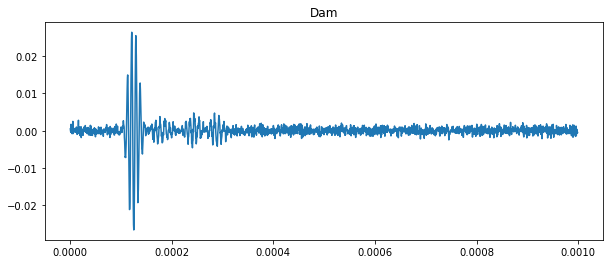

In [24]:
#---Plot non-noisy signal
D = random.randint(1, 2500)
print(D)

plt.figure(figsize=(10,4))
plt.plot(time[0:index-1], Xn3[D, 0 : index-1])
plt.title('Dam')

## New Dataset (with noise)

In [25]:
Xn = np.concatenate([X,Xn1,Xn2,Xn3], axis=0)
yn = np.concatenate([y,y,y,y], axis=0)
print(Xn.shape)
print(yn.shape)

(10000, 2000)
(10000, 2)


In [26]:
# call split function
[Xtrain,ytrain,Xvalid,yvalid,Xtest,ytest] = split2(Xn, yn, 0.1, 0.05)
print(Xtrain.shape)
print(Xtest.shape)

(8550, 2000)
(500, 2000)


In [27]:
# call model architecture
model = RNN(2000, 1, 16)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2000, 16)          1152      
_________________________________________________________________
dropout (Dropout)            (None, 2000, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               16384512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [28]:
# call train function
[Model, history] = train(Xtrain, ytrain, Xvalid, yvalid, model, 5e-5, 500, 8)

Train on 8550 samples, validate on 950 samples
Epoch 1/500
8550/8550 - 48s - loss: 0.0297 - mape: 99.9163 - mae: 0.1200 - r_square: 0.5409 - val_loss: 0.0246 - val_mape: 84.8595 - val_mae: 0.1076 - val_r_square: 0.6288
Epoch 2/500
8550/8550 - 45s - loss: 0.0268 - mape: 93.7698 - mae: 0.1139 - r_square: 0.5849 - val_loss: 0.0243 - val_mape: 87.3278 - val_mae: 0.1072 - val_r_square: 0.6257
Epoch 3/500
8550/8550 - 45s - loss: 0.0263 - mape: 91.0147 - mae: 0.1124 - r_square: 0.5843 - val_loss: 0.0242 - val_mape: 90.4868 - val_mae: 0.1073 - val_r_square: 0.6267
Epoch 4/500
8550/8550 - 46s - loss: 0.0259 - mape: 88.6285 - mae: 0.1116 - r_square: 0.5903 - val_loss: 0.0240 - val_mape: 76.6771 - val_mae: 0.1064 - val_r_square: 0.6327
Epoch 5/500
8550/8550 - 46s - loss: 0.0254 - mape: 87.5738 - mae: 0.1102 - r_square: 0.6027 - val_loss: 0.0237 - val_mape: 78.7573 - val_mae: 0.1059 - val_r_square: 0.6339
Epoch 6/500
8550/8550 - 46s - loss: 0.0249 - mape: 86.4659 - mae: 0.1089 - r_square: 0.6123 -

Epoch 49/500
8550/8550 - 46s - loss: 0.0015 - mape: 53.2752 - mae: 0.0292 - r_square: 0.9757 - val_loss: 9.1808e-04 - val_mape: 49.4944 - val_mae: 0.0222 - val_r_square: 0.9857
Epoch 50/500
8550/8550 - 46s - loss: 0.0015 - mape: 53.5358 - mae: 0.0289 - r_square: 0.9765 - val_loss: 8.4456e-04 - val_mape: 47.6696 - val_mae: 0.0213 - val_r_square: 0.9869
Epoch 51/500
8550/8550 - 46s - loss: 0.0014 - mape: 52.8854 - mae: 0.0282 - r_square: 0.9780 - val_loss: 8.3189e-04 - val_mape: 45.7013 - val_mae: 0.0210 - val_r_square: 0.9871
Epoch 52/500
8550/8550 - 46s - loss: 0.0014 - mape: 52.4313 - mae: 0.0281 - r_square: 0.9775 - val_loss: 7.8569e-04 - val_mape: 49.2303 - val_mae: 0.0204 - val_r_square: 0.9879
Epoch 53/500
8550/8550 - 46s - loss: 0.0014 - mape: 51.7267 - mae: 0.0278 - r_square: 0.9782 - val_loss: 8.0117e-04 - val_mape: 47.3660 - val_mae: 0.0205 - val_r_square: 0.9876
Epoch 54/500
8550/8550 - 46s - loss: 0.0013 - mape: 51.0567 - mae: 0.0271 - r_square: 0.9792 - val_loss: 7.4810e-04

Epoch 95/500
8550/8550 - 46s - loss: 7.1780e-04 - mape: 36.2706 - mae: 0.0197 - r_square: 0.9889 - val_loss: 3.6084e-04 - val_mape: 31.0857 - val_mae: 0.0141 - val_r_square: 0.9945
Epoch 96/500
8550/8550 - 46s - loss: 7.5312e-04 - mape: 36.2909 - mae: 0.0199 - r_square: 0.9883 - val_loss: 3.2454e-04 - val_mape: 30.8363 - val_mae: 0.0128 - val_r_square: 0.9950
Epoch 97/500
8550/8550 - 46s - loss: 7.2311e-04 - mape: 35.9779 - mae: 0.0197 - r_square: 0.9889 - val_loss: 3.1280e-04 - val_mape: 30.7254 - val_mae: 0.0128 - val_r_square: 0.9952
Epoch 98/500
8550/8550 - 46s - loss: 7.0453e-04 - mape: 35.9960 - mae: 0.0195 - r_square: 0.9891 - val_loss: 3.1691e-04 - val_mape: 29.0534 - val_mae: 0.0129 - val_r_square: 0.9952
Epoch 99/500
8550/8550 - 46s - loss: 7.3031e-04 - mape: 35.5550 - mae: 0.0197 - r_square: 0.9887 - val_loss: 3.1532e-04 - val_mape: 30.1858 - val_mae: 0.0128 - val_r_square: 0.9952
Epoch 100/500
8550/8550 - 46s - loss: 7.1583e-04 - mape: 35.7103 - mae: 0.0195 - r_square: 0.98

8550/8550 - 46s - loss: 5.7230e-04 - mape: 30.3721 - mae: 0.0174 - r_square: 0.9911 - val_loss: 2.1713e-04 - val_mape: 25.0166 - val_mae: 0.0105 - val_r_square: 0.9967
Epoch 141/500
8550/8550 - 46s - loss: 5.6311e-04 - mape: 30.9393 - mae: 0.0174 - r_square: 0.9912 - val_loss: 2.2003e-04 - val_mape: 24.8356 - val_mae: 0.0106 - val_r_square: 0.9966
Epoch 142/500
8550/8550 - 46s - loss: 5.6951e-04 - mape: 30.8986 - mae: 0.0173 - r_square: 0.9912 - val_loss: 2.1301e-04 - val_mape: 26.1082 - val_mae: 0.0103 - val_r_square: 0.9968
Epoch 143/500
8550/8550 - 46s - loss: 5.6314e-04 - mape: 30.6730 - mae: 0.0173 - r_square: 0.9912 - val_loss: 2.2524e-04 - val_mape: 25.5811 - val_mae: 0.0108 - val_r_square: 0.9965
Epoch 144/500
8550/8550 - 46s - loss: 5.3619e-04 - mape: 30.1467 - mae: 0.0170 - r_square: 0.9917 - val_loss: 2.3050e-04 - val_mape: 23.9256 - val_mae: 0.0111 - val_r_square: 0.9965
Epoch 145/500
8550/8550 - 46s - loss: 5.4384e-04 - mape: 30.6903 - mae: 0.0172 - r_square: 0.9915 - val_

Epoch 186/500
8550/8550 - 47s - loss: 4.7744e-04 - mape: 27.5278 - mae: 0.0160 - r_square: 0.9926 - val_loss: 1.7815e-04 - val_mape: 21.6964 - val_mae: 0.0097 - val_r_square: 0.9972
Epoch 187/500
8550/8550 - 46s - loss: 4.9606e-04 - mape: 27.7625 - mae: 0.0162 - r_square: 0.9922 - val_loss: 1.7259e-04 - val_mape: 21.1332 - val_mae: 0.0094 - val_r_square: 0.9973
Epoch 188/500
8550/8550 - 47s - loss: 4.7168e-04 - mape: 27.4042 - mae: 0.0158 - r_square: 0.9926 - val_loss: 1.6780e-04 - val_mape: 22.0654 - val_mae: 0.0096 - val_r_square: 0.9974
Epoch 189/500
8550/8550 - 48s - loss: 4.9357e-04 - mape: 27.3700 - mae: 0.0161 - r_square: 0.9923 - val_loss: 1.7576e-04 - val_mape: 20.5985 - val_mae: 0.0096 - val_r_square: 0.9972
Epoch 190/500
8550/8550 - 47s - loss: 4.7489e-04 - mape: 27.3258 - mae: 0.0159 - r_square: 0.9926 - val_loss: 1.6899e-04 - val_mape: 22.8428 - val_mae: 0.0096 - val_r_square: 0.9974
Epoch 191/500
8550/8550 - 47s - loss: 4.6974e-04 - mape: 26.8443 - mae: 0.0158 - r_square:

8550/8550 - 46s - loss: 4.4530e-04 - mape: 25.5545 - mae: 0.0153 - r_square: 0.9930 - val_loss: 1.3254e-04 - val_mape: 18.2698 - val_mae: 0.0085 - val_r_square: 0.9979
Epoch 232/500
8550/8550 - 47s - loss: 4.4581e-04 - mape: 25.4400 - mae: 0.0153 - r_square: 0.9929 - val_loss: 1.5337e-04 - val_mape: 20.3014 - val_mae: 0.0091 - val_r_square: 0.9976
Epoch 233/500
8550/8550 - 47s - loss: 4.4567e-04 - mape: 25.7374 - mae: 0.0153 - r_square: 0.9931 - val_loss: 1.4715e-04 - val_mape: 20.6166 - val_mae: 0.0088 - val_r_square: 0.9977
Epoch 234/500
8550/8550 - 46s - loss: 4.3843e-04 - mape: 25.5185 - mae: 0.0152 - r_square: 0.9931 - val_loss: 1.3309e-04 - val_mape: 19.3549 - val_mae: 0.0083 - val_r_square: 0.9979
Epoch 235/500
8550/8550 - 46s - loss: 4.3926e-04 - mape: 24.8558 - mae: 0.0152 - r_square: 0.9931 - val_loss: 1.3482e-04 - val_mape: 18.9007 - val_mae: 0.0086 - val_r_square: 0.9979
Epoch 236/500
8550/8550 - 46s - loss: 4.4361e-04 - mape: 25.7536 - mae: 0.0153 - r_square: 0.9930 - val_

Epoch 277/500
8550/8550 - 46s - loss: 4.0996e-04 - mape: 23.8094 - mae: 0.0146 - r_square: 0.9936 - val_loss: 1.2320e-04 - val_mape: 18.6549 - val_mae: 0.0081 - val_r_square: 0.9981
Epoch 278/500
8550/8550 - 46s - loss: 4.0770e-04 - mape: 24.1493 - mae: 0.0146 - r_square: 0.9937 - val_loss: 1.3090e-04 - val_mape: 17.9254 - val_mae: 0.0084 - val_r_square: 0.9980
Epoch 279/500
8550/8550 - 46s - loss: 4.1590e-04 - mape: 24.7388 - mae: 0.0147 - r_square: 0.9935 - val_loss: 1.4707e-04 - val_mape: 18.5109 - val_mae: 0.0088 - val_r_square: 0.9977
Epoch 280/500
8550/8550 - 46s - loss: 4.0484e-04 - mape: 23.7286 - mae: 0.0145 - r_square: 0.9937 - val_loss: 1.2536e-04 - val_mape: 20.4127 - val_mae: 0.0081 - val_r_square: 0.9981
Epoch 281/500
8550/8550 - 46s - loss: 4.1412e-04 - mape: 24.4847 - mae: 0.0146 - r_square: 0.9935 - val_loss: 1.2433e-04 - val_mape: 17.5330 - val_mae: 0.0081 - val_r_square: 0.9981
Epoch 282/500
8550/8550 - 46s - loss: 4.0957e-04 - mape: 24.3303 - mae: 0.0147 - r_square:

8550/8550 - 46s - loss: 3.9405e-04 - mape: 23.2980 - mae: 0.0143 - r_square: 0.9939 - val_loss: 1.0297e-04 - val_mape: 16.2109 - val_mae: 0.0075 - val_r_square: 0.9984
Epoch 323/500
8550/8550 - 46s - loss: 4.0074e-04 - mape: 23.2934 - mae: 0.0144 - r_square: 0.9937 - val_loss: 1.1333e-04 - val_mape: 16.7197 - val_mae: 0.0078 - val_r_square: 0.9982
Epoch 324/500
8550/8550 - 46s - loss: 4.0337e-04 - mape: 22.9180 - mae: 0.0143 - r_square: 0.9936 - val_loss: 1.0966e-04 - val_mape: 18.6570 - val_mae: 0.0077 - val_r_square: 0.9983
Epoch 325/500
8550/8550 - 46s - loss: 3.8203e-04 - mape: 23.0073 - mae: 0.0140 - r_square: 0.9940 - val_loss: 1.1461e-04 - val_mape: 16.1808 - val_mae: 0.0079 - val_r_square: 0.9983
Epoch 326/500
8550/8550 - 46s - loss: 3.9278e-04 - mape: 23.1923 - mae: 0.0142 - r_square: 0.9938 - val_loss: 1.0287e-04 - val_mape: 16.9223 - val_mae: 0.0073 - val_r_square: 0.9984
Epoch 327/500
8550/8550 - 46s - loss: 3.9521e-04 - mape: 23.5678 - mae: 0.0143 - r_square: 0.9938 - val_

Epoch 368/500
8550/8550 - 46s - loss: 3.6565e-04 - mape: 22.3525 - mae: 0.0137 - r_square: 0.9943 - val_loss: 1.0669e-04 - val_mape: 17.1545 - val_mae: 0.0077 - val_r_square: 0.9984
Epoch 369/500
8550/8550 - 46s - loss: 3.6285e-04 - mape: 22.2198 - mae: 0.0137 - r_square: 0.9944 - val_loss: 8.7337e-05 - val_mape: 16.2036 - val_mae: 0.0068 - val_r_square: 0.9986
Epoch 370/500
8550/8550 - 46s - loss: 3.7381e-04 - mape: 22.6831 - mae: 0.0138 - r_square: 0.9941 - val_loss: 9.0745e-05 - val_mape: 15.3396 - val_mae: 0.0070 - val_r_square: 0.9986
Epoch 371/500
8550/8550 - 46s - loss: 3.6063e-04 - mape: 22.8769 - mae: 0.0136 - r_square: 0.9944 - val_loss: 1.0031e-04 - val_mape: 17.9306 - val_mae: 0.0074 - val_r_square: 0.9984
Epoch 372/500
8550/8550 - 46s - loss: 3.7162e-04 - mape: 22.9026 - mae: 0.0139 - r_square: 0.9942 - val_loss: 9.9980e-05 - val_mape: 17.5425 - val_mae: 0.0075 - val_r_square: 0.9985
Epoch 373/500
8550/8550 - 46s - loss: 3.8061e-04 - mape: 22.3134 - mae: 0.0139 - r_square:

8550/8550 - 47s - loss: 3.6306e-04 - mape: 22.1803 - mae: 0.0136 - r_square: 0.9943 - val_loss: 9.1018e-05 - val_mape: 16.3121 - val_mae: 0.0069 - val_r_square: 0.9986
Epoch 414/500
8550/8550 - 46s - loss: 3.5845e-04 - mape: 21.9298 - mae: 0.0135 - r_square: 0.9943 - val_loss: 8.9585e-05 - val_mape: 15.6720 - val_mae: 0.0069 - val_r_square: 0.9986
Epoch 415/500
8550/8550 - 47s - loss: 3.5300e-04 - mape: 21.8156 - mae: 0.0134 - r_square: 0.9944 - val_loss: 8.5504e-05 - val_mape: 14.8077 - val_mae: 0.0068 - val_r_square: 0.9987
Epoch 416/500
8550/8550 - 47s - loss: 3.5588e-04 - mape: 21.5060 - mae: 0.0135 - r_square: 0.9943 - val_loss: 9.4007e-05 - val_mape: 15.1592 - val_mae: 0.0070 - val_r_square: 0.9985
Epoch 417/500
8550/8550 - 46s - loss: 3.6218e-04 - mape: 21.9524 - mae: 0.0136 - r_square: 0.9944 - val_loss: 9.6236e-05 - val_mape: 14.0549 - val_mae: 0.0073 - val_r_square: 0.9985
Epoch 418/500
8550/8550 - 47s - loss: 3.5127e-04 - mape: 21.7376 - mae: 0.0134 - r_square: 0.9945 - val_

Epoch 459/500
8550/8550 - 47s - loss: 3.5574e-04 - mape: 21.4293 - mae: 0.0135 - r_square: 0.9945 - val_loss: 8.5478e-05 - val_mape: 14.8415 - val_mae: 0.0068 - val_r_square: 0.9987
Epoch 460/500
8550/8550 - 47s - loss: 3.4204e-04 - mape: 21.2650 - mae: 0.0132 - r_square: 0.9946 - val_loss: 8.1619e-05 - val_mape: 15.3362 - val_mae: 0.0065 - val_r_square: 0.9987
Epoch 461/500
8550/8550 - 47s - loss: 3.4110e-04 - mape: 21.0596 - mae: 0.0132 - r_square: 0.9947 - val_loss: 7.9269e-05 - val_mape: 15.4251 - val_mae: 0.0065 - val_r_square: 0.9988
Epoch 462/500
8550/8550 - 47s - loss: 3.5524e-04 - mape: 21.2972 - mae: 0.0134 - r_square: 0.9944 - val_loss: 8.5665e-05 - val_mape: 15.3500 - val_mae: 0.0067 - val_r_square: 0.9987
Epoch 463/500
8550/8550 - 47s - loss: 3.3753e-04 - mape: 21.0910 - mae: 0.0131 - r_square: 0.9948 - val_loss: 7.9808e-05 - val_mape: 15.3359 - val_mae: 0.0066 - val_r_square: 0.9988
Epoch 464/500
8550/8550 - 47s - loss: 3.4276e-04 - mape: 21.2651 - mae: 0.0132 - r_square:

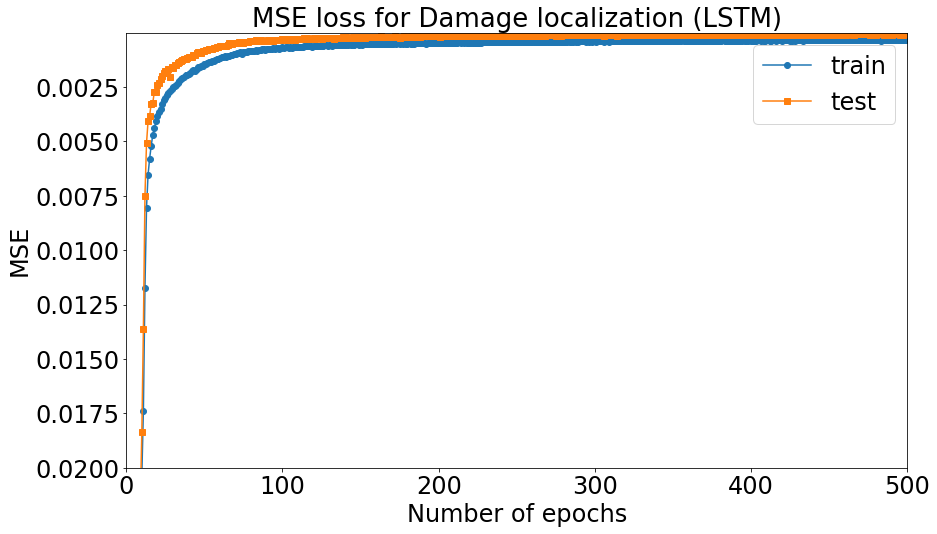

In [43]:
# call mseplot function
mseplot(history, 0.02, 1e-5, 24, 0, 500)

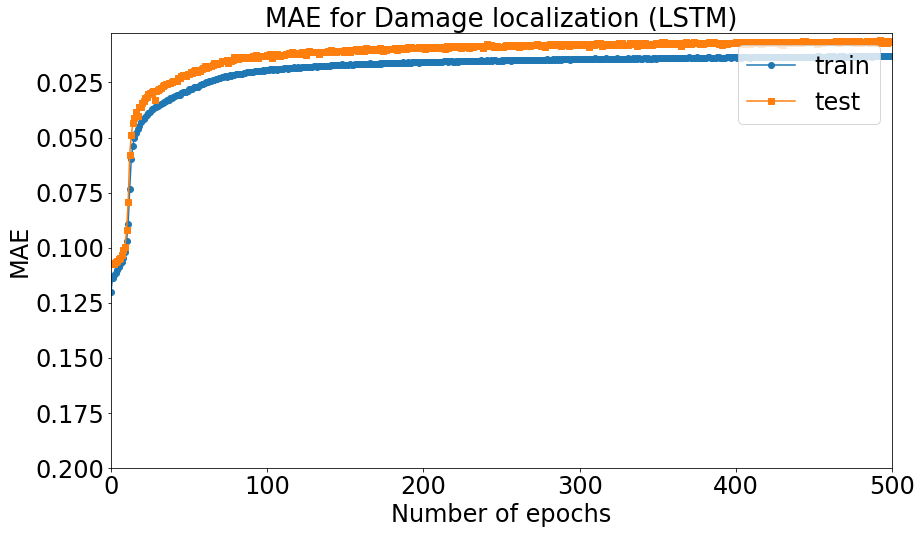

In [46]:
# call mae function
maeplot(history, 0.2, 0.0025, 24, 0, 500)

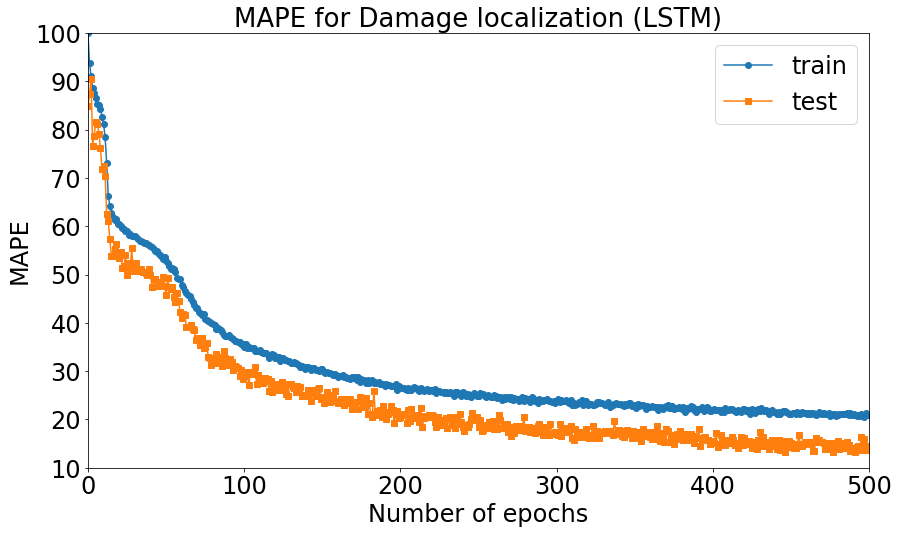

In [31]:
# call mape function
mapeplot(history, 10, 100, 24, 0, 500)

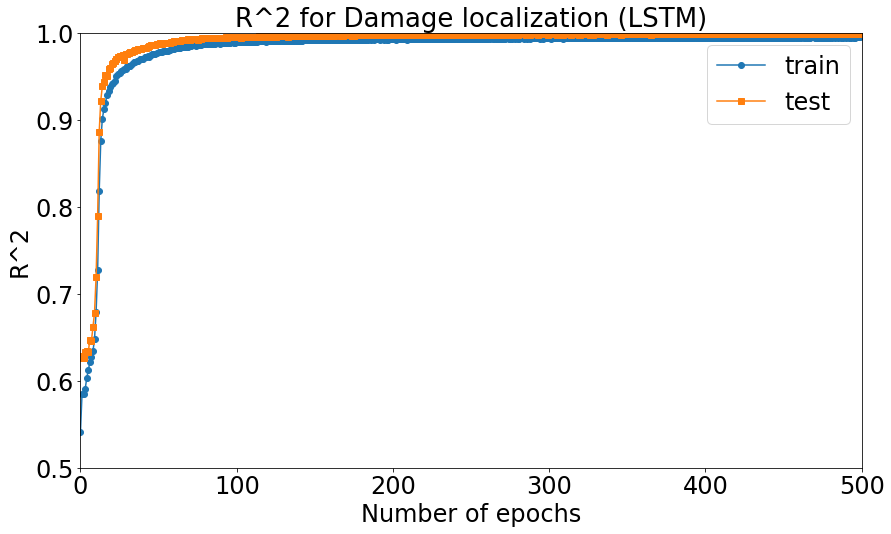

In [33]:
# call mape function
r2plot(history, 0.5, 1, 24, 0, 500)

In [47]:
# call pred function
pred(Model,Xtest,ytest,'LSTM_DamLocal.xlsx')

500/1 - 1s


,True values (x),True values (a),Predicted values (x),Predicted values (a),APD (x),APD (a)
0,0.482653,0.008878,0.480106,0.023984,0.53,170.16
1,0.758163,0.070918,0.767856,0.069037,1.28,2.65
2,0.620408,0.065102,0.614577,0.065440,0.94,0.52
3,0.773469,0.086429,0.782512,0.089071,1.17,3.06
4,0.712245,0.045714,0.674636,0.053129,5.28,16.22
...,...,...,...,...,...,...
495,0.145918,0.043776,0.151330,0.040444,3.71,7.61
496,0.773469,0.014694,0.770898,0.025647,0.33,74.54
497,0.100000,0.047653,0.101381,0.051126,1.38,7.29
498,0.773469,0.034082,0.787948,0.026818,1.87,21.31


In [ ]:
# trained model weights
#layer_weights = model.layers[0].get_weights()[0]
#print(layer_weights.shape)
#print(layer_weights)

In [ ]:
# trained model biases
#layer_biases  = model.layers[0].get_weights()[1]
#print(layer_biases.shape)
#print(layer_biases)

# Generalization on frequencies

In [53]:
df_Df100_Ax = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/0Dataset/Ax225_Df100_17Aug20.txt',header=None)
df_Df100_Flex = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/0Dataset/Flex225_Df100_17Aug20.txt',header=None)

df_Df150_Ax = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/0Dataset/Ax225_Df150_17Aug20.txt',header=None)
df_Df150_Flex = pd.read_csv('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/0Dataset/Flex225_Df150_17Aug20.txt',header=None)

y100 = pd.read_excel('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/f100/3Labels/labels100.xlsx',header=None)
y150 = pd.read_excel('D:/SDE/1_SDEisotropicDL/CollectData/4_TestSet/f150/3Labels/labels150.xlsx',header=None)

In [54]:
print(df_Df100_Ax.shape)
print(df_Df100_Flex.shape)
print(y100.shape)

print(df_Df150_Ax.shape)
print(df_Df150_Flex.shape)
print(y150.shape)

(225, 8192)
(225, 8192)
(225, 2)
(225, 8192)
(225, 8192)
(225, 2)


In [55]:
DAx100 = df_Df100_Ax.iloc[:, 0 : index]
DFlex100 = df_Df100_Flex.iloc[:, 0 : index]

DAx150 = df_Df150_Ax.iloc[:, 0 : index]
DFlex150 = df_Df150_Flex.iloc[:, 0 : index]

In [56]:
Xpred = DAx150  + DFlex150 # DAx150  + DFlex150 
Xpred = np.array(Xpred)
ypred = np.array(y150)/1000
print(Xpred.shape)
print(ypred.shape)

(225, 2000)
(225, 2)


In [57]:
# call pred function
pred(model,Xpred,ypred,'LSTM_DamLocal_pred150.xlsx')

225/1 - 0s


,True values (x),True values (a),Predicted values (x),Predicted values (a),APD (x),APD (a)
0,0.10,0.020000,0.423797,0.054451,323.80,172.25
1,0.10,0.024643,0.373199,0.053451,273.20,116.90
2,0.10,0.029286,0.402864,0.054266,302.86,85.30
3,0.10,0.033929,0.411426,0.054521,311.43,60.69
4,0.10,0.038571,0.410078,0.054292,310.08,40.76
...,...,...,...,...,...,...
220,0.85,0.066429,0.339542,0.054468,60.05,18.00
221,0.85,0.071071,0.407138,0.057543,52.10,19.04
222,0.85,0.075714,0.414394,0.054946,51.25,27.43
223,0.85,0.080357,0.421967,0.054869,50.36,31.72


# Generalization on noise

In [58]:
#---Random gaussian noise parameter
beta4 = 0.042
r = sigma*np.random.randn(2000,1) + mu   #random parameter with gaussian distribution
r = np.transpose(r)

#---Noisy signal
n4 = beta4*r*np.max(X)
Xn4 = X + n4

n = random.sample(range(1, Xn4.shape[0]), 225)
Xn4 = Xn4[n,:] # Xn should be defined
yn4 = y[n]   # yn should be defined
    
#---Signal to noise ratio
import math

rms_Xn4 = np.sqrt(np.mean(Xn4**2))
Power_Xn4 = rms_Xn4**2

rms_n4 = np.sqrt(np.mean(n4**2))
Power_n4 = rms_n4**2

SNR_dB = 10*math.log10(Power_Xn4/Power_n4)
print("SNR : ",SNR_dB)

SNR :  8.567352894620669


31


Text(0.5, 1.0, 'Dam')

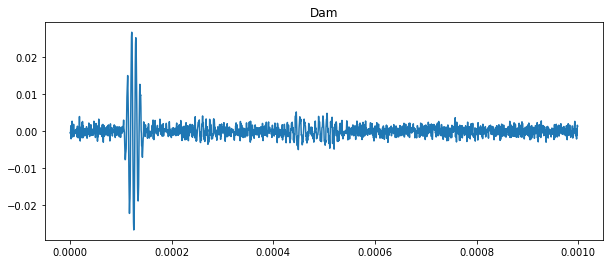

In [59]:
#---Plot non-noisy signal
Dp = random.randint(1, 225)
print(Dp)

plt.figure(figsize=(10,4))
plt.plot(time[0:index-1], Xn4[Dp, 0 : index-1])
plt.title('Dam')

In [60]:
# call pred function
pred(model,Xn4,yn4,'LSTM_DamLocal_predNoise.xlsx')

225/1 - 0s


,True values (x),True values (a),Predicted values (x),Predicted values (a),APD (x),APD (a)
0,0.742857,0.047653,0.740169,0.061613,0.36,29.30
1,0.467347,0.065102,0.472400,0.064933,1.08,0.26
2,0.819388,0.078673,0.600289,0.053817,26.74,31.59
3,0.681633,0.057347,0.508055,0.055911,25.47,2.50
4,0.804082,0.072857,0.783610,0.066003,2.55,9.41
...,...,...,...,...,...,...
220,0.559184,0.008878,0.529513,0.040785,5.31,359.42
221,0.513265,0.036020,0.468338,0.057983,8.75,60.97
222,0.543878,0.098061,0.660234,0.072596,21.39,25.97
223,0.467347,0.008878,0.498963,0.054600,6.76,515.03
